/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4
Imported nestcheck version: 0.2.1
this_directory:  /home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/J1808_synthetic
atmosphere_type: A
n_params: 5
Setting channels for loaded instrument response (sub)matrix...
Channels set.
No parameters supplied... empty subspace created.
Creating parameter:
    > Named "frequency" with fixed value 4.010e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:


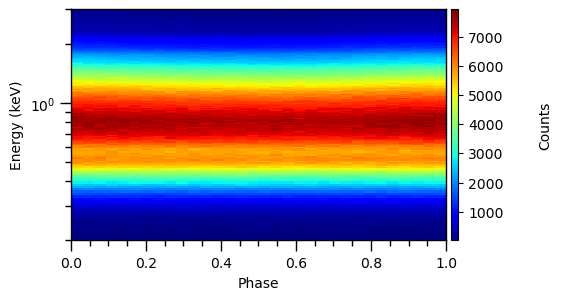

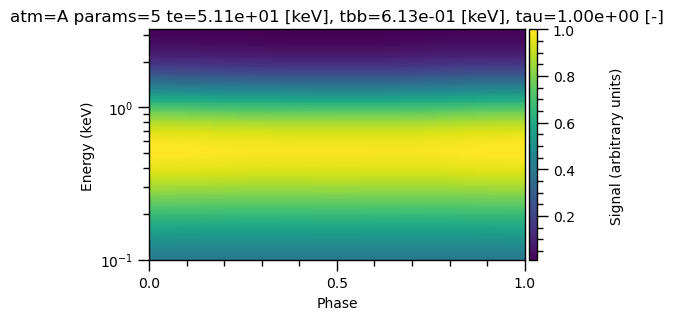

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys 
path="../"
sys.path.append(path)
path="../../"
sys.path.append(path)
import synthesise_J1808_data as ST
from custom_tools import get_mids_from_edges

# plot background from background model

In [2]:
exposure_time=1.32366e5 ## is the same as Mason 2019
print(ST.likelihood.signal._background.registered_background.shape)
synthesised_background = np.sum(ST.likelihood.signal._background.registered_background, axis=1)*exposure_time
synthesised_counts = ST.likelihood.signal.expected_counts
synthesised_signal = np.sum(ST.likelihood.signal.signals[0],axis=1)

(280, 32)


In [3]:
import xpsi
from CustomSignal import CustomSignal
import os
this_directory = os.getcwd()
datastring = this_directory + '/data/J1808_synthetic_realisation.dat' 

channel_low = 20
channel_hi = 300 #600
max_input = 1400 #2000
phases_space = np.linspace(0.0, 1.0, 33)


settings = dict(counts = np.loadtxt(datastring, dtype=np.double),
                channels=np.arange(channel_low,channel_hi),
                phases=phases_space,
                first=0, last=channel_hi-channel_low-1,
                exposure_time=exposure_time)

data_for_check = xpsi.Data(**settings)

signal_for_check = CustomSignal(data = data_for_check,
                        instrument = ST.NICER,  # Instrument
                        background = None,
                        interstellar = ST.interstellar,
                        cache = True,
                        prefix='Instrument')

likelihood_for_check = xpsi.Likelihood(star = ST.star, signals = signal_for_check,
                             num_energies=128, 
                             threads=8, #1
                             externally_updated=True,
                             prior = ST.prior)

p_cut = ST.p[:-3]
# p_cut.append(6.5)
# p_cut.append(0.0)
column_density = 1.17 #10^21 cm^-2
p_cut.append(column_density)

likelihood_for_check(p_cut, reinitialise=True)

Setting channels for event data...
Channels set.
Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].


-46404.12522540618

In [4]:
marginalized_background = likelihood_for_check.signal.background_signal
marginalized_counts = likelihood_for_check.signal.expected_counts

Text(0, 0.5, 'counts')

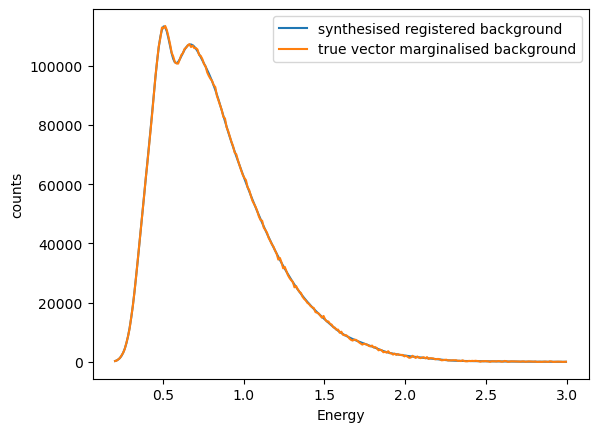

In [5]:
fig, ax = plt.subplots()

channel_mids = get_mids_from_edges(ST.NICER.channel_edges)

ax.plot(channel_mids, synthesised_background, label='synthesised registered background')
ax.plot(channel_mids, marginalized_background, label='true vector marginalised background')
ax.legend()
ax.set_xlabel('Energy')

ax.set_ylabel('counts')

/tmp/ipykernel_2311509/168024408.py:2: RuntimeWarning: divide by zero encountered in true_divide
  ratio=synthesised_background/marginalized_background


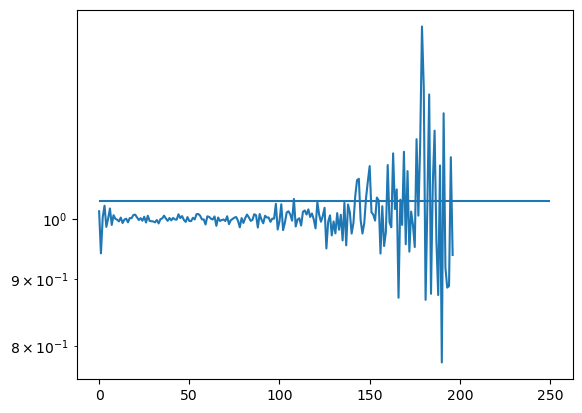

In [6]:
fig,ax=plt.subplots()
ratio=synthesised_background/marginalized_background
ax.semilogy(ratio[3:200])
ax.hlines(33/32,0,250)

In [7]:
33/32

1.03125

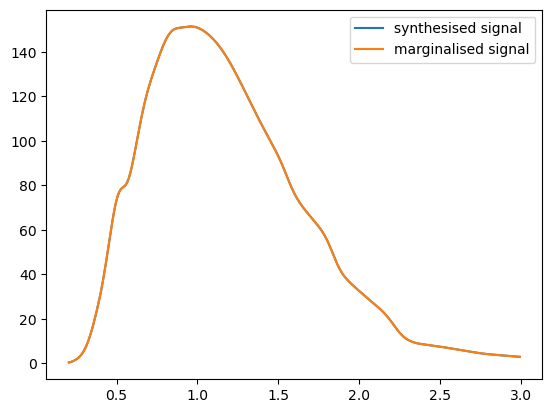

In [8]:
fig,ax = plt.subplots()
ax.plot(channel_mids, synthesised_signal, label='synthesised signal')
ax.plot(channel_mids, np.sum(likelihood_for_check.signal.signals[0],axis=1),label='marginalised signal')
ax.legend()

Text(0, 0.5, 'counts')

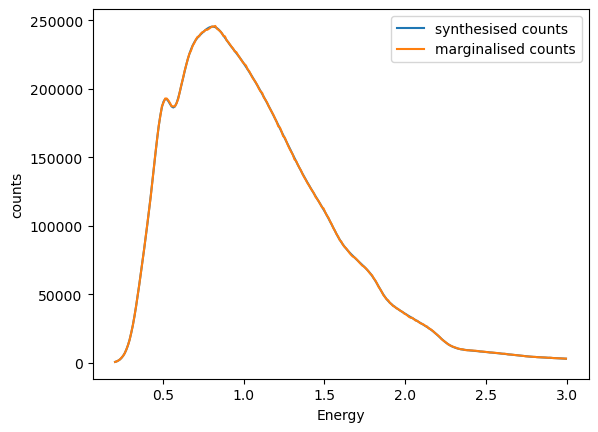

In [9]:
fig, ax = plt.subplots()

channel_mids = get_mids_from_edges(ST.NICER.channel_edges)

ax.plot(channel_mids, np.sum(synthesised_counts,axis=1), label='synthesised counts')
ax.plot(channel_mids, np.sum(marginalized_counts,axis=1), label='marginalised counts')
ax.legend()
ax.set_xlabel('Energy')
ax.set_ylabel('counts')